In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34
from torch import nn
import torch.optim as optim
from torch import nn
import copy
import pruning_funcs
import numpy as np
import matplotlib.pyplot as plt

In [66]:
# Transform and Load CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data/train', train=True, download=True,transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data/test', train=False, download=True,transform=transform_test)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [67]:
# Modify ResNet34 Architecture for CIFAR-10
class ModifiedResNet34(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedResNet34, self).__init__()
        self.model = resnet34(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.avgpool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Dropout(0.5))  
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

In [73]:
# Setup GPU 
device = torch.device("mps")
model = ModifiedResNet34().to(device)

In [69]:
def evaluate_model(testing_model, dataloader, suppress_output=False):
    testing_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = testing_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if not suppress_output:
        print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

In [70]:
# Loss function, optimizer, hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

In [ ]:
# Traning Loop
def train_model(model, debug_interval = 200, save_model=True, use_saved_state=True):
    for epoch in range(num_epochs):  
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Print statistics
            running_loss += loss.item()
            if i % debug_interval == debug_interval-1:
                print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss: {running_loss / 200:.4f}')
                print(f'\tAcc (Test data): {evaluate_model(model, testloader, suppress_output=True)}')
                running_loss = 0.0
    if save_model:
        torch.save(model.state_dict(), "resnet_state")
    print('Finished Training')

In [75]:
# train_model(model, debug_interval = 200, save_model=True)
# Load the state dictionary from the file
state_dict = torch.load("resnet_state")
new_state_dict = {f'model.{k}': v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
# evaluate_model(model, testloader)

<All keys matched successfully>

In [ ]:
# Bernulli Pruning [Poor Results]
%load_ext autoreload
%autoreload now

percent_prune = []
percent_prune_with_bernoulli = []
percents = np.arange(1,10,1)

for percent in percents:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.percent_prune(pruned_model, device, percent=percent)
    percent_prune.append(evaluate_model(pruned_model, testloader, suppress_output=True))
    
    ppwb_runs = []
    for i in range(5):
        pruned_model_2 = copy.deepcopy(model)
        pruning_funcs.percent_prune_with_bernoulli(pruned_model_2, device, percent=(2*percent), p_success=0.5)
        ppwb_runs.append(evaluate_model(pruned_model_2, testloader, suppress_output=True))

    percent_prune_with_bernoulli.append(np.mean(ppwb_runs))

fig, ax = plt.subplots()
ax.set_title("Percent Pruning")
line1, = ax.plot(percents, percent_prune, color='blue')
line2, = ax.plot(percents, percent_prune_with_bernoulli, color='orange')
line1.set_label("Percent Pruning")
line2.set_label("Percent Pruning With Bernoulli (avg)")
ax.legend()
ax.set_xlabel("Percent pruned (or expected pruned)")
ax.set_ylabel("Model accuracy")
ax.set_xticks(percents)

Text(0.5, 0, 'Scale = 0.25')

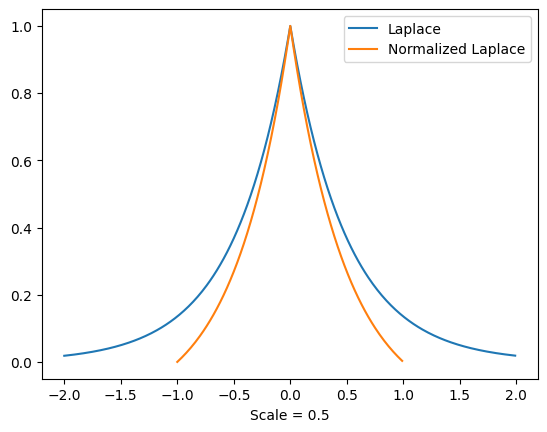

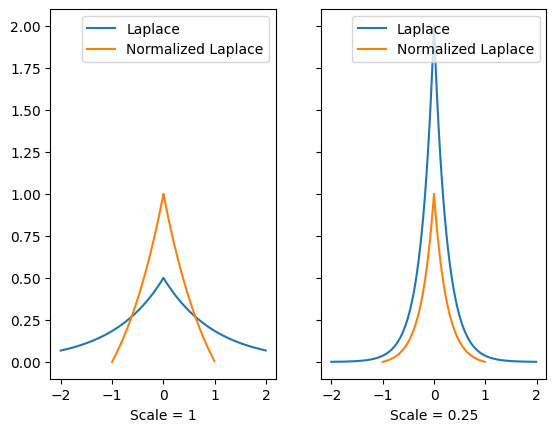

In [56]:
# Graph Laplace Distribution
import numpy as np
import matplotlib.pyplot as plt

def laplace_at(x, loc=0, scale=0.5):
    return np.exp(-abs(x-loc)/scale)/(2.*scale)

def graph_laplace_and_normalized(scale, loc=0, min=1):
    x = np.arange(-2, 2, 0.01)
    normalized_x = np.arange(-1, 1, 0.01)

    laplace_dist = lambda y: laplace_at(y, scale=scale, loc=loc)
    pdf = laplace_dist(x)
    normalized_pdf = (laplace_dist(normalized_x) - laplace_dist(min)) / (laplace_dist(loc) - laplace_dist(min))
    return ((x, pdf),(normalized_x, normalized_pdf))

((x, pdf), (x2, modified_pdf)) = graph_laplace_and_normalized(0.5)
fig, ax = plt.subplots()
line1, = ax.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax.legend()
ax.set_xlabel('Scale = 0.5')

((x, pdf), (x2, modified_pdf)) = graph_laplace_and_normalized(1)
((x3, pdf2), (x4, modified_pdf2)) = graph_laplace_and_normalized(0.25)

fig2, (ax1, ax2) = plt.subplots(1,2, sharey=True)
line1, = ax1.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax1.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax1.legend()
ax1.set_xlabel('Scale = 1')
line3, = ax2.plot(x3, pdf2)
line3.set_label('Laplace')
line4, = ax2.plot(x4, modified_pdf2)
line4.set_label('Normalized Laplace')
ax2.legend()
ax2.set_xlabel('Scale = 0.25')


In [76]:
%load_ext autoreload
%autoreload now
import pruning_funcs
import copy

tests = np.arange(0.001, 0.01, 0.001)
num_trials = 5

print()
print('Avg. accuracy at scale values for Normalized Laplace Distribution')

print()
print('Unpruned Model')
accuracy = evaluate_model(model, testloader, suppress_output=True)
percent_zero = pruning_funcs.percent_zero_weights(model)
print(f'Accuracy: {accuracy:.2f}%\tPercent Zero: {percent_zero:.2f}%')

print()
print("Pruned Models (Normalized Laplace)")
for prune_scale in tests:
    accuracy = 0.
    percent_zeros = 0.
    for i in range(num_trials):
        pruned_model = copy.deepcopy(model)
        pruning_funcs.normalized_laplace_prune(pruned_model, device, scale=prune_scale)
        accuracy += evaluate_model(pruned_model, testloader, suppress_output=True)
        percent_zeros += pruning_funcs.percent_zero_weights(pruned_model)
    accuracy /= num_trials
    percent_zeros /= num_trials
    print(f'Scale: {prune_scale:.3f}\tAvg. Accuracy: {accuracy:.2f}%\tAvg. Percent Zero: {percent_zeros:.2f}%')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Avg. accuracy at scale values for Normalized Laplace Distribution

Unpruned Model
Accuracy: 95.46%	Percent Zero: 0.00%

Pruned Models (Normalized Laplace)
Scale: 0.001	Avg. Accuracy: 95.43%	Avg. Percent Zero: 6.09%
Scale: 0.002	Avg. Accuracy: 95.45%	Avg. Percent Zero: 11.90%
Scale: 0.003	Avg. Accuracy: 95.33%	Avg. Percent Zero: 17.32%
Scale: 0.004	Avg. Accuracy: 95.24%	Avg. Percent Zero: 22.30%
Scale: 0.005	Avg. Accuracy: 95.16%	Avg. Percent Zero: 26.84%
Scale: 0.006	Avg. Accuracy: 95.08%	Avg. Percent Zero: 30.94%
Scale: 0.007	Avg. Accuracy: 94.91%	Avg. Percent Zero: 34.66%
Scale: 0.008	Avg. Accuracy: 94.62%	Avg. Percent Zero: 38.03%
Scale: 0.009	Avg. Accuracy: 94.44%	Avg. Percent Zero: 41.09%


In [57]:
percents = np.arange(1,6,1)
print("Pruned Models (Standard Percent Pruning)")
for percent in percents:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.percent_prune(pruned_model, device, percent=percent)
    accuracy = evaluate_model(pruned_model, testloader, suppress_output=True)
    percent_zero = pruning_funcs.percent_zero_weights(pruned_model)
    print(f'Theoretic percent pruned: {percent}%\tActual percent pruned: {percent_zero:.2f}%\tAccuracy: {accuracy:.2f}%')

Pruned Models (Standard Percent Pruning)
Theoretic percent pruned: 1%	Actual percent pruned: 1.00%	Accuracy: 95.35%
Theoretic percent pruned: 2%	Actual percent pruned: 2.00%	Accuracy: 95.05%
Theoretic percent pruned: 3%	Actual percent pruned: 3.00%	Accuracy: 94.76%
Theoretic percent pruned: 4%	Actual percent pruned: 4.00%	Accuracy: 94.17%
Theoretic percent pruned: 5%	Actual percent pruned: 5.00%	Accuracy: 93.98%
